# Self Supervised Deepfake Detection - Lev Ayzenberg and Shir Bar
### Final project in Deep Learning Course, taught by Professor Raja Giryes at Tel Aviv University
This notebook enables training and evaluation of a SimCLR implementation modified for use on Deepfake Detection task on the FaceForensics++.
We provide an easy interface for training a contrastive model with the notebook using Google Colab, evaluating it using linear evaluation or KNN anomaly detection algorithm, and then present tSNE representations of the latent space.

In [1]:
# set the cd to the code and dataset folders:
import os
import sys
ROOT_PATH = '/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch'
FF_PATH = '/media/shirbar/My Passport/FaceForensics/sample_ds'
sys.path.append(ROOT_PATH)

In [2]:
cd {ROOT_PATH}

/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch


In [3]:
#%matplotlib widget
import pandas as pd
import sys
import subprocess
import torch
import numpy as np
import fileinput
import matplotlib.pyplot as plt
import torch.distributed as dist
import models
from dfd_utils.FaceForensicsDataset import FaceForensicsDataset
from dfd_utils.utils import plot_images, get_embeds, plot_embeddings_2D, plot_embeddings_3D
from dfd_utils.ImageAugmentation import get_transforms
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
from torchvision import transforms
from utils.datautils import CenterCropAndResize
import torch.nn.functional as F
from sklearn.manifold import TSNE
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors
from torchvision import transforms, utils, datasets
import cv2
from facenet_pytorch import MTCNN
import random
from utils.datautils import CenterCropAndResize

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CONFIG_FILE_PATH = os.path.join(ROOT_PATH, 'configs','ff_train.yaml')
LIN_CLASSIFIER_CONFIG_FILE_PATH = os.path.join(ROOT_PATH, 
                                               'configs','ff_eval.yaml')
EVAL_CONFIG_FILE_PATH = os.path.join(ROOT_PATH, 
                                               'configs','ff_eval.yaml')

### Print Help

In [ ]:
cmd = f'python train.py --help --problem sim-clr'
!{cmd}

args: Namespace(ckpt='', config_file=None, deepfakes=False, dist='dp', dist_address='127.0.0.1:1234', eval_freq=10000000000000000, eval_only=False, faceforensics_path='/media/shirbar/My Passport/FaceForensics/split_ds/', iters=-1, log_freq=100, lr=0.1, lr_schedule='warmup-anneal', name='', new_transforms=True, node_rank=0, opt='lars', pretrained=False, problem='sim-clr', root='/mnt/results', save_freq=10000000000000000, seed=-1, tmp=False, verbose=False, warmup=0, weight_decay=0.0001, workers=4, world_size=1)
usage: train.py [-h] [--config CONFIG_FILE] [--tmp]
                [--problem {sim-clr,eval,semi-supervised-eval}] [--name NAME]
                [--ckpt CKPT] [--verbose VERBOSE] [--lr_schedule LR_SCHEDULE]
                [--opt {sgd,adam,lars}] [--iters ITERS] [--warmup WARMUP]
                [--lr LR] [--wd WEIGHT_DECAY] [--save_freq SAVE_FREQ]
                [--log_freq LOG_FREQ] [--eval_freq EVAL_FREQ] [-j WORKERS]
                [--eval_only EVAL_ONLY] [--seed SEED] [--r

In [ ]:
cmd = f'python train.py --help --problem eval'
!{cmd}

### Train SimCLR Model

In [ ]:
batch_size = 32
cmd = f'python train.py --config "{CONFIG_FILE_PATH}" --dist dp ' +\
f'--dist_address localhost:8888 --node_rank 0 --faceforensics_path "{FF_PATH}" '+\
f'--batch_size {batch_size}'
!{cmd}

args: Namespace(ckpt='', config_file='/content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312201288_301782983/configs/ff_train.yaml', deepfakes=False, dist='dp', dist_address='localhost:8888', eval_freq=330, eval_only=False, faceforensics_path='/content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312201288_301782983/sample_ds', iters=11000, log_freq=110, lr=0.3, lr_schedule='warmup-anneal', name='ff-full-contrastive', new_transforms=True, node_rank=0, opt='lars', pretrained=False, problem='sim-clr', root='/mnt/results', save_freq=220, seed=42, tmp=False, verbose=True, warmup=0.1, weight_decay=1e-06, workers=8, world_size=1)
arch: ResNet50
aug: true
batch_size: 32
ckpt: ''
color_dist_s: 1.0
config_file: /content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312201288_301782983/configs/ff_train.yaml
data: faceforensics
deepfakes: false
dist: dp
dist_address: localhost:8888
eval_freq: 330
eval_only: false
faceforensics_path: /content/dr

### Train Linear Classifier

In [ ]:
encoder_path = os.path.join(ROOT_PATH, 'trained_models', 'encoders', 
                            'simclr_new_transforms_real_epoch_11000.pth.tar')
cmd = f'python train.py --config "{LIN_CLASSIFIER_CONFIG_FILE_PATH}" ' +\
 f'--dist dp --encoder_ckpt "{encoder_path}" --faceforensics_path "{FF_PATH}"'
!{cmd}

### Eval Base Model

In [ ]:
# Eval base model
cmd = f'python train.py --config "{EVAL_CONFIG_FILE_PATH}" ' +\
  f'--dist dp --encoder_ckpt "{encoder_path}" --faceforensics_path "{FF_PATH}"'
!{cmd}

args: Namespace(ckpt='', config_file='/content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312201288_301782983/configs/ff_eval.yaml', deepfakes=True, dist='dp', dist_address='', eval_freq=4375, eval_only=False, faceforensics_path='/content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312201288_301782983/sample_ds', iters=87500, log_freq=438, lr=0.0125, lr_schedule='linear', name='eval_faceforensics', new_transforms=False, node_rank=0, opt='sgd', pretrained=False, problem='eval', root='/mnt/results', save_freq=3500, seed=42, tmp=False, verbose=False, warmup=0.0, weight_decay=0.0, workers=8, world_size=1)
arch: linear
aug: true
augmentation: RandomResizedCrop
batch_size: 32
ckpt: ''
config_file: /content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312201288_301782983/configs/ff_eval.yaml
data: faceforensics
deepfakes: true
dist: dp
dist_address: ''
encoder_ckpt: /content/drive/MyDrive/PhD/Courses/Deep Learning/Deep Learning/project_312

# Compare the perfomance of the linear classifier to that of the KNN algorithm:
specifically we wanted to test the ability to detect different types of deepfake manipulations even ones not used in training
We want to evaluate these two method using 3 different encoders to create the latent space - SimCLR with the original augmentations, SimCLR with the new FF oriented augmentations and a ResNet-50 pretrained on ImageNet (no contrastive training)


## Load models:

In [6]:
def load_eval_model(eval_model_path, encoder_path):
    ckpt = torch.load(eval_model_path, map_location= DEVICE)
    ckpt['hparams'].deepfakes = False # don't put deepfakes in the train set
    ckpt['hparams'].encoder_ckpt = encoder_path
    ckpt['hparams'].faceforensics_path = FF_PATH
    model = models.ssl.SSLEval.load(ckpt, device=DEVICE)
    model.encoder.eval()
    model.eval()
    return model

#### Here you can find all the models we tested:
original_aug_model   -> simclr encoder, original augmentations, pre-trained on Imagenet <br>
new_aug_model        -> simclr encoder, blackout augmentations, pre-trained on Imagenet <br>
new_aug_no_pre_model -> simclr encoder, blackout augmentations, not pre-trained on Imagenet <br>
resnet_model         -> resnet50 encoder, no augmentations, pre-trained on Imagenet <br>

In [ ]:
trained_models_folder = '/media/shirbar/My Passport/trained_models' # Change this to the folder containing trained models


model_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_original_augs_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_original_augs_pretrained_resnet.pth.tar')
original_aug_model = load_eval_model(model_path, encoder_path)


model_path2 = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_new_augs_pretrained_100epochs.pth.tar')
encoder_path2 = os.path.join(trained_models_folder,'encoders',
                                'simclr_new_augs_pretrained_only_real.pth.tar')
new_aug_model = load_eval_model(model_path2, encoder_path2)


model_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_new_augs_no_pretrain_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_new_transforms_real_epoch_11000.pth.tar')
new_aug_no_pre_model = load_eval_model(model_path, encoder_path)


resnet_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_resnet_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                                   'andrew_resnet.pth.tar')
resnet_model = load_eval_model(model_path, encoder_path)


# Load train dataset and create/load embeddings:
creating the embeddings may take some time, you can optionally upload them from a saved file

In [ ]:
# the train set images are the same for all models so we can just load the train set once:
original_aug_model.prepare_data()
train_loader, test_loader = original_aug_model.dataloaders()
train_loader.dataset.dataset.dataset.transform = test_loader.dataset.dataset.dataset.transform

In [ ]:
_, original_aug_train_embeds, train_targets = get_embeds(original_aug_model, train_loader)
_, new_aug_train_embeds, _ = get_embeds(new_aug_model, train_loader)
_, new_aug_no_pre_train_embeds, _ = get_embeds(new_aug_no_pre_model, train_loader)
_, resnet_train_embeds,_ = get_embeds(resnet_model, train_loader)


In [ ]:
# save your embeddings if you wish:
torch.save({'embeddings': original_aug_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/original_augs_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_all_train_set_embeds_real.pt')
torch.save({'embeddings': resnet_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/resnet_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_no_pre_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_no_pre_train_embeds2, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real2.pt')


## alternatively you can load the embeddings we used from file:

In [9]:
org_aug_path = os.path.join(ROOT_PATH, 'trained_models/embeddings/original_augs_all_train_set_embeds_real.pt')
new_aug_path = os.path.join(ROOT_PATH, 'trained_models/embeddings/new_augs_all_train_set_embeds_real.pt')
new_aug_no_pre_path = os.path.join(ROOT_PATH, 'trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt')
new_aug_no_pre_path2 = os.path.join(ROOT_PATH, 'trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt')
resnet_path = os.path.join(ROOT_PATH, 'trained_models/embeddings/resnet_all_train_set_embeds_real.pt')

chkpt = torch.load(org_aug_path)
original_aug_train_embeds, train_targets = chkpt['embeddings'], chkpt['targets']
chkpt = torch.load(new_aug_path)
new_aug_train_embeds = chkpt['embeddings']
chkpt = torch.load(new_aug_no_pre_path)
new_aug_no_pre_train_embeds = chkpt['embeddings']
chkpt = torch.load(new_aug_no_pre_path2)
new_aug_no_pre_train_embeds2 = chkpt['embeddings']
chkpt = torch.load(resnet_path)
resnet_train_embeds = chkpt['embeddings']

#### FaceForensicsDataset loading function

In [10]:
def load_ff_ds_test(wanted_ds_size,
                    batch_size,
                    load_deepfakes=False,
                    load_face2face=False,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=None,
                   split='test'):
    TEST_DATASET_PATH = os.path.join(FF_PATH, split)
    ff_ds_test  = FaceForensicsDataset(TEST_DATASET_PATH,
                                    transform=transform,
                                    load_deepfakes=load_deepfakes,
                                    load_face2face=load_face2face,
                                    load_neural_textures=load_neural_textures,
                                  masking_transforms=masking_transforms)
    if split == 'test':
        ff_ds_test.equalize_real_fakes()
    
    if wanted_ds_size != -1:
        test_size = int(0.8 * len(ff_ds_test))
        ts_size = len(ff_ds_test) - test_size

        test_dataset,_ = torch.utils.data.random_split(ff_ds_test, [test_size, ts_size], 
                                                       generator=torch.Generator().manual_seed(42))
        test_subset = Subset(test_dataset, list(range(0, min(len(test_dataset),
                                                             wanted_ds_size))))
    else:
        test_subset = ff_ds_test

    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle = False)

    print('test size:', test_subset.__len__())
    return test_loader

clean_transform = transforms.Compose([
                CenterCropAndResize(proportion=0.95, size=224),
                transforms.ToTensor(),
                lambda x: (255 * x).byte(),
            ])

## Plot Embeddings

We provide a sample dataset containing frames from one identity from the train split of FF++ and one identity from the test split. We have the same identity in all classes - Real, DF, NT and F2F. For the manipulated video we took the video that has the same context as the identity but a different face/expression is implanted in it. <br />
Below we plot results, using the test set identity, for each manipulation embeddings against the unmanipulated embeddings. <br />
You can use this code to produce the tSNE graphs provided in our reports, if you download and extract the full FF++ dataset.

### Load Model

In [61]:
# Choose which model you want to use to plot:
#model = new_aug_no_pre_model
model = resnet_model
#model = new_aug_model
#model = original_aug_model

### Load FaceForensics Dataset

## Deepfakes

In [25]:
df_test_loader = load_ff_ds_test(1000, 16, load_deepfakes=True, transform=clean_transform)

loading real images...
real images loaded!
loading deepfakes...
deepfakes loaded!
real imgs len: 847
masks len: 847
fakes imgs len: 1381
fakes masks len: 1381
final imgs len: 2228
final masks len: 2228
asserting order
assertion passed!
before eq: real: 847  fake: 1381  total: 2228
after eq: total: 1694
test size: 1000


In [62]:
#Get test embeddings:
unnorm_embeds, embeds, targets = get_embeds(model, df_test_loader, DEVICE, out='h')

100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


### Plot example images

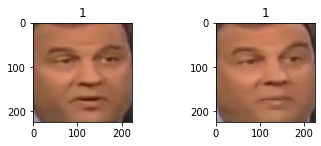

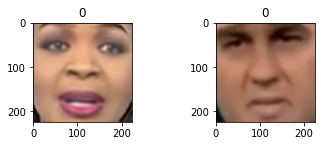

In [27]:
images1, images2, labels = next(iter(df_test_loader))
images1 = images1[labels==1] #real samples are labeled 1
images2 = images2[labels==0] # fake samples are labeled 0
plot_images(images1[2:], np.ones(len(images1[2:]),dtype=int).tolist(), max_num_images_to_plt=2)
plot_images(images2[2:], np.zeros(len(images2[2:]),dtype=int), max_num_images_to_plt=2)

### 2D Embeddings - Deepfakes + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.850499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.351990
[t-SNE] KL divergence after 1000 iterations: 0.503747
num categories: 2


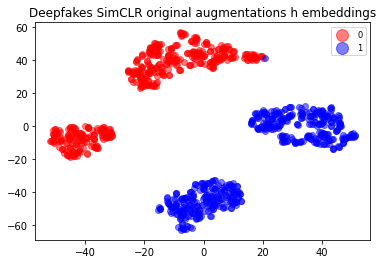

In [63]:
plot_embeddings_2D(embeds.tolist(), targets.tolist(), 'Deepfakes SimCLR original augmentations h embeddings')

### 3D Embeddings - Deepfakes + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 656 samples in 0.075s...
[t-SNE] Computed neighbors for 656 samples in 0.866s...
[t-SNE] Computed conditional probabilities for sample 656 / 656
[t-SNE] Mean sigma: 1.895168
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.539017
[t-SNE] KL divergence after 1000 iterations: 0.516786


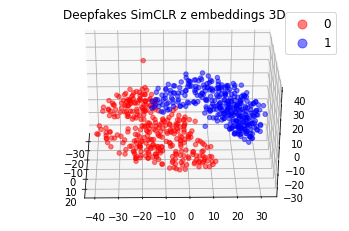

In [ ]:
plot_embeddings_3D(embeds.tolist(), targets.tolist(), 'Deepfakes SimCLR z embeddings 3D')

## Face2Face

In [ ]:
f2f_test_loader = load_ff_ds_test(2000, 16, load_face2face=True, transform=clean_transform)

loading real images...
real images loaded!
loading face2face...
face2face loaded!
real imgs len: 410
masks len: 410
fakes imgs len: 962
fakes masks len: 962
final imgs len: 1372
final masks len: 1372
asserting order
assertion passed!
before eq: real: 410  fake: 962  total: 1372
after eq: total: 820
test size: 656


In [ ]:
# Get test embeddings:
f2f_unnorm_embeds, f2f_embeds, f2f_targets = get_embeds(model, f2f_test_loader, DEVICE, out='h')

  0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 41/41 [03:46<00:00,  5.53s/it]


### Plot example images

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


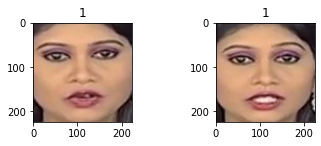

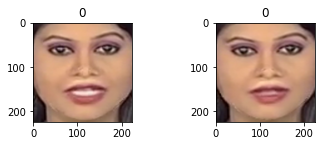

In [ ]:
images1, images2, labels = next(iter(f2f_test_loader))
images1 = images1[labels==1] #real samples are labeled 1
images2 = images2[labels==0] # fake samples are labeled 0
plot_images(images1[2:], np.ones(len(images1[2:]),dtype=int).tolist(), max_num_images_to_plt=2)
plot_images(images2[2:], np.zeros(len(images2[2:]),dtype=int), max_num_images_to_plt=2)

### 2D Embeddings - Face2Face + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 656 samples in 0.081s...
[t-SNE] Computed neighbors for 656 samples in 0.866s...
[t-SNE] Computed conditional probabilities for sample 656 / 656
[t-SNE] Mean sigma: 1.896062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.189178
[t-SNE] KL divergence after 1000 iterations: 0.510319
num categories: 2


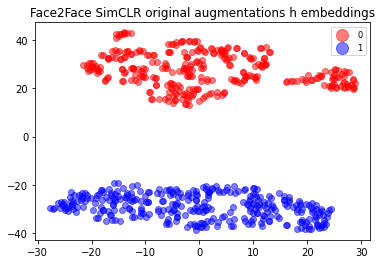

In [ ]:
plot_embeddings_2D(f2f_embeds.tolist(), f2f_targets.tolist(), 'Face2Face SimCLR original augmentations h embeddings')

### 3D Embeddings - Face2Face + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 656 samples in 0.079s...
[t-SNE] Computed neighbors for 656 samples in 0.861s...
[t-SNE] Computed conditional probabilities for sample 656 / 656
[t-SNE] Mean sigma: 1.896062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.682373
[t-SNE] KL divergence after 1000 iterations: 0.660102


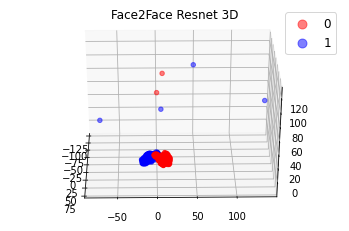

In [ ]:
plot_embeddings_3D(f2f_embeds.tolist(), f2f_targets.tolist(), 'Face2Face Resnet 3D')

## NeuralTextures

In [ ]:
nt_test_loader = load_ff_ds_test(2000, 16, load_neural_textures=True, transform=clean_transform)

loading real images...
real images loaded!
loading neural textures...
neural textures loaded!
real imgs len: 410
masks len: 410
fakes imgs len: 410
fakes masks len: 410
final imgs len: 820
final masks len: 820
asserting order
assertion passed!
before eq: real: 410  fake: 410  total: 820
after eq: total: 820
test size: 656


In [ ]:
# Get test embeddings:
nt_unnorm_embeds, nt_embeds, nt_targets = get_embeds(model, nt_test_loader, DEVICE, out='h')

  0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 41/41 [00:21<00:00,  1.92it/s]


### Plot example images

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


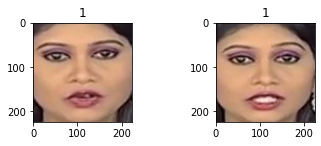

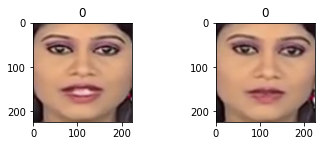

In [ ]:
images1, images2, targets = next(iter(nt_test_loader))
images1 = images1[labels==1] #real samples are labeled 1
images2 = images2[labels==0] # fake samples are labeled 0
plot_images(images1[2:], np.ones(len(images1[2:]),dtype=int).tolist(), max_num_images_to_plt=2)
plot_images(images2[2:], np.zeros(len(images2[2:]),dtype=int), max_num_images_to_plt=2)

### 2D Embeddings - NeuralTextures + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 656 samples in 0.096s...
[t-SNE] Computed neighbors for 656 samples in 0.870s...
[t-SNE] Computed conditional probabilities for sample 656 / 656
[t-SNE] Mean sigma: 1.805379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.012497
[t-SNE] KL divergence after 1000 iterations: 0.546729
num categories: 2


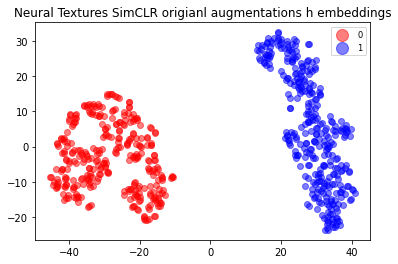

In [ ]:
plot_embeddings_2D(nt_embeds.tolist(), nt_targets.tolist(), 'Neural Textures SimCLR origianl augmentations h embeddings')

### 3D Embeddings - NeuralTextures + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 656 samples in 0.091s...
[t-SNE] Computed neighbors for 656 samples in 0.880s...
[t-SNE] Computed conditional probabilities for sample 656 / 656
[t-SNE] Mean sigma: 1.805379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.451309
[t-SNE] KL divergence after 1000 iterations: 0.597722


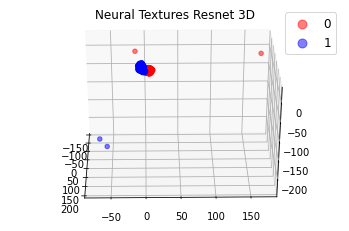

In [ ]:
plot_embeddings_3D(nt_embeds.tolist(), nt_targets.tolist(), 'Neural Textures Resnet 3D')

## Evaluate embeddings using both linear evaluation and KNN

### Function for model evaluation function for the linear classifier:


In [12]:
@torch.no_grad()
def eval_model_classification(model,h,targets):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    h = h.to(device)
    targets = targets.to(device)
    pred = model(h)
    pred = F.softmax(pred,dim=1)
    pred_classes = torch.argmax(pred, dim=1)
    total_correct = (pred_classes==targets).sum()
    acc = total_correct / len(targets) * 100
    print('\ntotal real:', targets.sum(), ' total fake:', 
          len(targets) - targets.sum())
    print('total correct:', total_correct, ' out of:', len(targets))
    print(f'\nACC: {acc}')
    return acc, pred_classes, targets

### Functions for KNN based classifier:

after https://arxiv.org/abs/2002.10445, the semi supervised setting


In [13]:
def get_train_knns(train_embeds, k=3,p=2):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto',p=p).fit(train_embeds) 
    train_knns, _ = nbrs.kneighbors(train_embeds)
    train_knns = train_knns[:,1:] # remove first column as it is only zeros (each vector's dist to itself)
    nbrs.n_neighbors = k # return back to k, the test vecs won't be in the train set 
    return nbrs, train_knns

def get_test_knns(train_neighbors,test_embeds,k=3):
    assert train_neighbors.n_neighbors == k
    test_knns, _ = train_neighbors.kneighbors(test_embeds.cpu())
    return test_knns

def eval_model_knns(test_embeds, test_targets, train_neighbors, train_knns,k=3):
    test_knns = get_test_knns(train_neighbors,test_embeds,k)
    # Note: the paper didn't specify how/what was their thresholding for the KNN distances, so we 
    # selected to use the 95th quantile of the KNN distances of the training data, additional tuning on the
    # validation set will probably yield better results.
    thresh = np.quantile(test_knns,0.44) 
    # real has a label of 1 so anything below the thresh should be labelled 1:
    predictions = (test_knns.mean(axis=1)<thresh).astype(int) 
    predictions = torch.Tensor(predictions)
    total_correct = (predictions==test_targets).sum()
    acc = total_correct / len(test_knns) * 100
    return acc, predictions, test_targets, thresh

### Calculate KNN and linear evaluations for all models:
To evaluate a single model, set the desired model name and manipulation type in the cell below

In [80]:
df_test_loader = load_ff_ds_test(1000, 16, load_deepfakes=True, transform=clean_transform)
f2f_test_loader = load_ff_ds_test(1000, 16, load_face2face=True, transform=clean_transform)
nt_test_loader = load_ff_ds_test(1000, 16, load_neural_textures=True, transform=clean_transform)

loaders_dict = {'df' : df_test_loader,
           'f2f' : f2f_test_loader, 
           'nt' : nt_test_loader}
models_dict = {'original_augs' : original_aug_model, #original augmentations initialized with pre-trained resnet 
          'new_augs' : new_aug_model, #blackout initialized with pre-trained resnet 
          'new_augs_no_pre' : new_aug_no_pre_model, #blackout initialized with random weights
          'resnet':resnet_model} # resnet pre-trained on imagenet with no contrastive training
embeds_dict = {'original_augs' : original_aug_train_embeds, 
               'new_augs': new_aug_train_embeds, 
               'new_augs_no_pre' : new_aug_no_pre_train_embeds,
               'resnet':resnet_train_embeds}

# Choose model and manipulation method:
model_name = 'new_augs_no_pre' # Change this to desired model name for testing
assert model_name in models_dict.keys()
model = models_dict[model_name]
train_embeds = embeds_dict[model_name]

manipulation = 'df' # Change this to desired manipulation
assert manipulation in loaders_dict.keys()
test_loader = loaders_dict[manipulation]


loading real images...
real images loaded!
loading deepfakes...
deepfakes loaded!
real imgs len: 847
masks len: 847
fakes imgs len: 1381
fakes masks len: 1381
final imgs len: 2228
final masks len: 2228
asserting order
assertion passed!
before eq: real: 847  fake: 1381  total: 2228
after eq: total: 1694
test size: 1000


#### Calculate test embeddings and metrics:

In [81]:
# choose K for KNN:
K = 21 #  We found by experimenting on the validation set this brought the best results

# Get test embeddings:
_, test_embeds,test_targets = get_embeds(model,test_loader,device=DEVICE,
                                        div=True)
# Perform linear eval:
c_acc,c_pred,c_tar = eval_model_classification(model,test_embeds,test_targets)

# The knn part may take a bit of time to calculate, depending on train and test sizes
train_nn, train_knns = get_train_knns(train_embeds.cpu(), k=K)  
k_acc,k_pred,k_tar,k_thresh = eval_model_knns(test_embeds, test_targets, 
                                              train_nn, train_knns,k=K)
print(f'model: {model_name}, manipulation: {manipulation}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')

100%|██████████| 63/63 [00:20<00:00,  3.13it/s]



total real: tensor(519, device='cuda:0')  total fake: tensor(481, device='cuda:0')
total correct: tensor(1000, device='cuda:0')  out of: 1000

ACC: 100.0
model: new_augs_no_pre, manipulation: df, linear eval accuracy: 100.00, knn accuracy: 96.60


### Compare all models and manipulations and save results to file:

In [68]:
K = 21 # We found by experimenting on the validation set this brought the best results

results_df = pd.DataFrame(columns=['model_name', 'deepfake_method',
                                   'classification_accuracy', 'knn_accuracy',
                                  'knn_dist_threshold','train_size','test_size'])
for model_name, model in models_dict.items():
    train_embeds = embeds_dict[model_name]
    train_embeds = train_embeds[train_targets==1] #we use only "normal" aka real samples for the train set
    print(f'Calculating KNNs on {model_name} model embeddings')
    # get the sklearn Nearest Neighbor calculator and the KNN distances of the train set, the latter will be used
    # for thresholding the test set to determine "anomalies" aka fake samples:
    #train_nn, train_knns = get_train_knns(train_embeds.cpu(), k=K)  
    for loader_name, loader in loaders_dict.items():
        print(f'Getting test embeddings')
        undiv_embeds, test_embeds,test_targets = get_embeds(model,loader,div=True)
        print(f'Performing linear eval on {manipulation}')
        c_acc,c_pred,c_tar = eval_model_classification(model,test_embeds,test_targets)
        print(f'Calculating {manipulation} KNNs')
        k_acc,k_pred,k_tar,k_thresh = eval_model_knns(test_embeds, test_targets, train_nn, train_knns,k=K)
        print(f'model: {model_name}, manipulation: {manipulation}, linear eval accuracy: {c_acc:.2f}, knn accuracy: {k_acc:.2f}')
        results_df = results_df.append({'model_name' : model_name, 
                                        'deepfake_method' : loader_name,
                                        'classification_accuracy' : c_acc, 
                                        'knn_accuracy' : k_acc,
                                       'knn_dist_threshold':k_thresh,
                                       'train_size': len(train_knns),
                                       'test_size': len(loader.dataset)}, ignore_index=True)
        
results_path = os.path.join(ROOT_PATH, 'results_df.csv')
#results_df.to_csv(results_path)
print(f'Saved results to file at {results_path}')

  0%|          | 0/63 [00:00<?, ?it/s]

Calculating KNNs on original_augs model embeddings
Getting test embeddings


100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


Performing linear eval on df

total real: tensor(519, device='cuda:0')  total fake: tensor(481, device='cuda:0')
total correct: tensor(1000, device='cuda:0')  out of: 1000

ACC: 100.0
Calculating df KNNs


  0%|          | 0/43 [00:00<?, ?it/s]

model: original_augs, manipulation: df, linear eval accuracy: 100.00, knn accuracy: 90.00
Getting test embeddings


 26%|██▌       | 11/43 [00:03<00:10,  2.99it/s]


KeyboardInterrupt: 